## Generate

In [1]:
!mpfrom __future__ import division
import math
import numpy as np
import scipy.linalg
from scipy.stats import norm
from collections import Counter
from tqdm import tqdm

import warnings



def locate_centroids(clus_cfg):
    """
    Generate locations for the centroids of the clusters.
    Args:
        clus_cfg (clusters.DataConfig): Configuration.
    Returns:
        np.array: Matrix (n_clusters, n_feats) with positions of centroids.
    """
    centroids = np.zeros((clus_cfg.n_clusters, clus_cfg.n_feats))

    p = 1.
    idx = 1
    for i, c in enumerate(clus_cfg._cmax):
        p *= c
        if p > 2 * clus_cfg.n_clusters + clus_cfg.outliers / clus_cfg.n_clusters:
            idx = i
            break
    idx += 1
    locis = np.arange(p)
    np.random.shuffle(locis)
    clin = locis[:clus_cfg.n_clusters]

    # voodoo magic for obtaining centroids
    res = clin
    parametr_dist=list(zip(*clus_cfg.parametres_distributions))[1]
    for j in range(idx):
        center = ((res % clus_cfg._cmax[j]) + 1) / (clus_cfg._cmax[j] + 1)
        noise = (np.random.rand(clus_cfg.n_clusters) - 0.5) * parametr_dist
        
        centroids[:, j] = center + noise
        res = np.floor(res / clus_cfg._cmax[j])
    for j in range(idx, clus_cfg.n_feats):
        center = np.floor(clus_cfg._cmax[j] * np.random.rand(clus_cfg.n_clusters) + 1) / (clus_cfg._cmax[j] + 1)
        noise = (np.random.rand(clus_cfg.n_clusters) - 0.5) * parametr_dist
        
        centroids[:, j] = center + noise

    return centroids, locis, idx


def generate_clusters(clus_cfg, batch_size = 0):
    """
    Generate data.
    Args:
        clus_cfg (clusters.DataConfig): Configuration.
        batch_size (int): Number of samples for each batch.
    Yields:
        np.array: Generated samples.
        np.array: Labels for the samples.
    """
    # generate correlation and rotation matrices
    for cluster in clus_cfg.clusters:
        # generate random symmetric matrix with ones in the diagonal
        # uses the vine method described here
        # http://stats.stackexchange.com/questions/2746/how-to-efficiently-generate-random-positive-semidefinite-correlation-matrices
        # using the correlation input parameter to set a threshold on the values of the correlation matrix
        corr = np.eye(clus_cfg.n_feats)
        aux = np.zeros(corr.shape)

        beta_param = 4

        for k in range(clus_cfg.n_feats - 1):
            for i in range(k + 1, clus_cfg.n_feats):
                aux[k, i] = 2 * cluster.corr * (np.random.beta(beta_param, beta_param) - 0.5)
                p = aux[k, i]
                for l in range(k - 1, -1, -1):
                    p = p * np.sqrt((1 - aux[l, i]**2) * (1 - aux[l, k]**2)) + aux[l, i] * aux[l, k]
                corr[k, i] = p
                corr[i, k] = p
        perm = np.random.permutation(clus_cfg.n_feats)
        corr = corr[perm, :][:, perm]
        cluster.corr_matrix = np.linalg.cholesky(corr)
        cluster.correlation_matrix = corr

        # rotation matrix
        if cluster.rotate:
            cluster.rotation_matrix = get_rotation_matrix(clus_cfg.n_feats)

    if batch_size == 0:
        batch_size = clus_cfg.n_samples
    for batch in range(((clus_cfg.n_samples - 1) // batch_size) + 1):
        n_samples = min(batch_size, clus_cfg.n_samples - batch * batch_size)
        data, labels = compute_batch(clus_cfg, n_samples)
        yield data, np.reshape(labels, (len(labels), 1))


def get_rotation_matrix(n_feats):
    rot_mat = 2 * (np.random.rand(n_feats, n_feats) - 0.5)
    ort = scipy.linalg.orth(rot_mat)
    if ort.shape == rot_mat.shape:  # check if `rot_mat` is full rank, so that `ort` keeps the same shape
        return ort
    else:
        return get_rotation_matrix(n_feats)


def compute_batch(clus_cfg, n_samples):
    """
    Generates one batch of data.
    Args:
        clus_cfg (clusters.DataConfig): Configuration.
        n_samples (int): Number of samples in the batch.
    Returns:
        np.array: Generated sample.
    """
    # get probabilities of each class
    s=np.array(clus_cfg.clusters_label)
    labels = np.random.choice(s, n_samples, p=clus_cfg.weight_cluster) 

    data = np.zeros((n_samples, clus_cfg.n_feats))
    # setUp centroids
    for lab in clus_cfg.centroids_.keys():
      clus_cfg._centroids[lab]=clus_cfg.centroids_[lab]


    # setUP overlapping
    if clus_cfg.chevauchement is not None: 
      indexes_overLap : dict = {}
      list_label_overlap= set(list(zip(*clus_cfg.chevauchement))[0]+list(zip(*clus_cfg.chevauchement))[1])

  
    # generate samples for each cluster    
    for (label,param,shape )in tqdm( zip(clus_cfg.clusters_label,clus_cfg.parametres_shapes,clus_cfg._shapes) ):
        d_tot=[]
        cluster = clus_cfg.clusters[label]
        indexes = (labels == label)
        # save indexes of overlaps clusters
        if clus_cfg.chevauchement is not None and label in list_label_overlap :
          indexes_overLap[label]=indexes 
        samples = sum(indexes)  # nbr of samples in this cluster
        while len(d_tot)<samples:
          points=cluster.generate_data(samples*5)
          d_iter=apply_cdt(points,clus_cfg._centroids[label],clus_cfg.par_shapes[label][1])
          if clus_cfg.par_shapes[label][0] is not None:
            d_iter=clus_cfg.par_shapes[label][0](d_iter,clus_cfg._centroids[label],clus_cfg.par_shapes[label][1],'+')
           
            if clus_cfg.shapes[label] is not None:
              d_tot+=verify_shape(d_iter,shape,param,cluster,samples,clus_cfg,label)
            else:
              d_tot+=d_iter  
          else:
            d_tot+=d_iter

          
        data[indexes] = d_tot[:samples]
        

        # apply rotation
        if cluster.rotate:
            data[indexes] = data[indexes].dot(cluster.rotation_matrix)

        # apply overlapping
        if clus_cfg.chevauchement is not None :
          for (i,(l1,l2,percent)) in enumerate(clus_cfg.chevauchement):
              if l1 in indexes_overLap.keys() and  l2 in indexes_overLap.keys():
                  if np.any(clus_cfg._centroids[l1]<clus_cfg._centroids[l2]):
                    xd=clus_cfg._centroids[l1]+clus_cfg.par_shapes[l1][1]
                    d_= data[indexes_overLap[l2]]+xd+clus_cfg.par_shapes[l2][1]-clus_cfg._centroids[l2]
                    if clus_cfg.par_shapes[l1][0] is not None:
                      d_=clus_cfg.par_shapes[l1][0](d_,clus_cfg._centroids[l1],clus_cfg.par_shapes[l1][1],'+')
                      if clus_cfg.shapes[l1] is not None:
                        d_=verify_shape(d_,clus_cfg._shapes[l1],clus_cfg.parametres_shapes[l1],cluster,samples,clus_cfg,label)
                    result=[point for point in d_ if np.any(np.array(point)< np.amax(data[indexes_overLap[l1]])) and  np.any(np.array(point)<np.amax(data[indexes_overLap[l1]]))]
                    P=len(result)/samples
                    xdmin=xd
                    p_opt=P
                    nb_opt=len(result)
                    if P>percent:
                      while np.all(np.array(xd)<= np.array(clus_cfg._centroids[l1]+clus_cfg.par_shapes[l1][1])) and np.all(np.array(xd) >=np.array(clus_cfg._centroids[l1]-clus_cfg.par_shapes[l1][1])) and round(percent,2)!=round(P,2):
                          xd = xd+clus_cfg.par_shapes[l1][1]*0.01
                          d_= data[indexes_overLap[l2]]+xd+clus_cfg.par_shapes[l2][1]-clus_cfg._centroids[l2]
                          if clus_cfg.par_shapes[l1][0] is not None:
                            d_=clus_cfg.par_shapes[l1][0](d_,clus_cfg._centroids[l1],clus_cfg.par_shapes[l1][1],'+')
                            if clus_cfg.shapes[l1] is not None:
                              d_=verify_shape(d_,clus_cfg._shapes[l1],clus_cfg.parametres_shapes[l1],cluster,samples,clus_cfg,label) 
                          result=[point for point in d_ if np.any(np.array(point)< np.amax(data[indexes_overLap[l1]])) and  np.any(np.array(point)<np.amax(data[indexes_overLap[l1]]))]
                          P=len(result)/samples
                          if np.abs(P-percent)<np.abs(p_opt-percent):
                            xdmin=xd
                            p_opt=P
                            nb_opt=len(result)

                      d_f= data[indexes_overLap[l2]]+xdmin+clus_cfg.par_shapes[l2][1]-clus_cfg._centroids[l2]
                      clus_cfg.chevauchement= clus_cfg.chevauchement[1:]
                      print('--------------- Overlapp between', l1, '&', l2, '-------------')
                      print('Optimal percent =',p_opt, 'corresponding to',nb_opt,'points on the overlap')
                      if p_opt<percent:
                          print('\n')
                          print(warnings.warn('\n Warning : the percentage of overlap achieved is less than the desired percentage' ))

                    else:
                      while (percent > P ) and np.all(np.array(xd) <= np.array(clus_cfg._centroids[l1]+clus_cfg.par_shapes[l1][1])) and np.all(np.array(xd) >=np.array(clus_cfg._centroids[l1]-clus_cfg.par_shapes[l1][1])) and round(percent,2)!=round(P,2):
                        xd = xd-clus_cfg.par_shapes[l1][1]*0.01
                        d_= data[indexes_overLap[l2]]+xd+clus_cfg.par_shapes[l2][1]-clus_cfg._centroids[l2]
                        if clus_cfg.par_shapes[l1][0] is not None:
                          d_=clus_cfg.par_shapes[l1][0](d_,clus_cfg._centroids[l1],clus_cfg.par_shapes[l1][1],'+')
                          if clus_cfg.shapes[l1] is not None:
                            d_=verify_shape(d_,clus_cfg._shapes[l1],clus_cfg.parametres_shapes[l1],cluster,samples,clus_cfg,label)
                        result=[point for point in d_ if np.any(np.array(point)< np.amax(data[indexes_overLap[l1]])) and  np.any(np.array(point)<np.amax(data[indexes_overLap[l1]]))]
                        P=len(result)/samples
                        if np.abs(P-percent)<np.abs(p_opt-percent):
                          xdmin=xd
                          p_opt=P
                          nb_opt=len(result)
                      d_f= data[indexes_overLap[l2]]+xdmin+clus_cfg.par_shapes[l2][1]-clus_cfg._centroids[l2]
                      clus_cfg.chevauchement= clus_cfg.chevauchement[1:]
                      print('--------------- Overlapp between', l1, '&', l2, '-------------')
                      print('Optimal percent =',p_opt, 'corresponding to',nb_opt,'points on the overlap')
                      if p_opt<percent:
                          print('\n')
                          print(warnings.warn('\n Warning : the percentage of overlap achieved is less than the desired percentage' ))



                  else:
                    xd=clus_cfg._centroids[l1]-clus_cfg.par_shapes[l1][1]
                    d_= data[indexes_overLap[l2]]+xd-clus_cfg.par_shapes[l2][1]-clus_cfg._centroids[l2]
                    if clus_cfg.par_shapes[l1][0] is not None:
                      d_=clus_cfg.par_shapes[l1][0](d_,clus_cfg._centroids[l1],clus_cfg.par_shapes[l1][1],'+')
                      if clus_cfg.shapes[l1] is not None:
                        d_=verify_shape(d_,clus_cfg._shapes[l1],clus_cfg.parametres_shapes[l1],cluster,samples,clus_cfg,label)
                    result=[point for point in d_ if np.any(np.array(point)< np.amax(data[indexes_overLap[l1]])) and  np.any(np.array(point)<np.amax(data[indexes_overLap[l1]]))]
                    P=len(result)/samples 
                    xdmin=xd
                    p_opt=P
                    nb_opt=len(result)
                    if P>percent:
                      while np.all( np.array(xd) <= np.array(clus_cfg._centroids[l1]+clus_cfg.par_shapes[l1][1])) and np.all(np.array(xd) >=np.array(clus_cfg._centroids[l1]-clus_cfg.par_shapes[l1][1])) and round(percent,2)!=round(P,2):
                          xd = xd-clus_cfg.par_shapes[l1][1]*0.01
                          d_= data[indexes_overLap[l2]]+xd-clus_cfg.par_shapes[l2][1]-clus_cfg._centroids[l2]
                          if clus_cfg.par_shapes[l1][0] is not None:
                            d_=clus_cfg.par_shapes[l1][0](d_,clus_cfg._centroids[l1],clus_cfg.par_shapes[l1][1],'+')
                            if clus_cfg.shapes[l1] is not None:
                              d_=verify_shape(d_,clus_cfg._shapes[l1],clus_cfg.parametres_shapes[l1],cluster,samples,clus_cfg,label)
                          result=[point for point in d_ if np.any(np.array(point)< np.amax(data[indexes_overLap[l1]])) and  np.any(np.array(point)<np.amax(data[indexes_overLap[l1]]))]
                          P=len(result)/samples
                          if np.abs(P-percent)<np.abs(p_opt-percent):
                            xdmin=xd
                            p_opt=P
                            nb_opt=len(result)

                      d_f= data[indexes_overLap[l2]]+xdmin-clus_cfg.par_shapes[l2][1]-clus_cfg._centroids[l2]
                      clus_cfg.chevauchement= clus_cfg.chevauchement[1:]
                      print('--------------- Overlapp between', l1, '&', l2, '-------------')
                      print('Optimal percent =',p_opt, 'corresponding to',nb_opt,'points on the overlap')
                      if p_opt<percent:
                          print('\n')
                          print(warnings.warn('\n Warning : the percentage of overlap achieved is less than the desired percentage' ))

                    else:
                      while np.all( np.array(xd) <= np.array(clus_cfg._centroids[l1]+clus_cfg.par_shapes[l1][1])) and np.all(np.array(xd) >=np.array(clus_cfg._centroids[l1]-clus_cfg.par_shapes[l1][1])) and round(percent,2)!=round(P,2):
                        xd = xd+clus_cfg.par_shapes[l1][1]*0.01
                        d_= data[indexes_overLap[l2]]+xd-clus_cfg.par_shapes[l2][1]-clus_cfg._centroids[l2]
                        if clus_cfg.par_shapes[l1][0] is not None:
                          d_=clus_cfg.par_shapes[l1][0](d_,clus_cfg._centroids[l1],clus_cfg.par_shapes[l1][1],'+')
                          if clus_cfg.shapes[l1] is not None:
                            d_=verify_shape(d_,clus_cfg._shapes[l1],clus_cfg.parametres_shapes[l1],cluster,samples,clus_cfg,label)
                        result=[point for point in d_ if np.any(np.array(point)< np.amax(data[indexes_overLap[l1]])) and  np.any(np.array(point)<np.amax(data[indexes_overLap[l1]]))]
                        P=len(result)/samples
                        if np.abs(P-percent)<np.abs(p_opt-percent):
                          nb_opt=len(result)
                          xdmin=xd
                          p_opt=P

                      d_f= data[indexes_overLap[l2]]+xdmin-clus_cfg.par_shapes[l2][1]-clus_cfg._centroids[l2]
                      clus_cfg.chevauchement= clus_cfg.chevauchement[1:]
                      data[indexes_overLap[l2]]=d_f
                      print('--------------- Overlapp between', l1, '&', l2, '-------------')
                      print('Optimal percent =',p_opt, 'corresponding to',nb_opt,'points on the overlap')
                      if p_opt <percent:
                          print('\n')
                          print(warnings.warn('\n Warning : the percentage of overlap achieved is less than the desired percentage' ))


    return data, labels

/bin/bash: mpfrom: command not found


## Init


In [2]:

from numbers import Number
import random
import math
import six
import numpy as np


class ClusterGenerator(object):
    """
    Structure to handle the input and create clusters according to it.
    """
    def  __init__(self, seed=1, n_samples=2000, n_feats=3, k=5,clusters_label=None,centroids=None,par_shapes=None,weight_cluster=None, 
                  distributions=None,parametres_distributions=None,
                  scale=True, rotate=True,shapes=None,chevauchement=None,parametres_shapes=None, **kwargs):


        self.seed = seed
        self.n_samples = n_samples if n_samples is not None else 800
        self.n_feats = n_feats if n_feats is not  None else 3 
        self.k = k if k is not None else 1
        self.clusters_label=clusters_label if clusters_label is not None else [i for i in range(k)] 
        self.centroids_=centroids if centroids is not None else {}
        self.par_shapes=par_shapes if par_shapes is not None else {}
        self.n_clusters = len(k) if type(k) == list else k
        self.weight_cluster=weight_cluster if weight_cluster is not None else [1/k for _ in range(k)] 
        self.min_samples = 0
        self.possible_distributions = ['gaussian', 'uniform']
        self.distributions = distributions
        self.parametres_distributions =parametres_distributions if parametres_distributions is not None else {}
        self.mv = True
        self.corr = 0
        self.alpha_n = 7
        self._cmax = None
        self.scale = scale
        self.outliers = 0
        self.rotate = rotate
        self.add_noise = 0
        self.n_noise =[]
        self.ki_coeff = 0
        self.shapes=shapes
        self.chevauchement=chevauchement
        self.parametres_shapes=parametres_shapes if parametres_shapes is not None else {}
        random.seed(self.seed)

        random.seed(self.seed)
        for key, val in kwargs.items():
            self.__dict__[key] = val

        self._distributions = None
        self._shapes=None
        self._validate_parameters()
        self.clusters = self.get_cluster_configs()

        self._centroids = None
        self._locis = None
        self._idx = None


    def generate_data(self, batch_size=0):
        np.random.seed(self.seed)
        self._centroids, self._locis, self._idx = locate_centroids(self)
        batches = generate_clusters(self, batch_size)
        if batch_size == 0:  # if batch_size == 0, just return the data instead of the generator
            return next(batches)
        else:
            return batches

    def get_cluster_configs(self):
        return [Cluster(self, i) for i in range(self.n_clusters)]

    def _validate_parameters(self):
        """
        Method to validate the parameters of the object.
        """
        if hasattr(self.k, '__iter__'):
            if len(self.k) == 1:  # if only one input, no point in being a list
                self.k = self.k[0]
                self.n_clusters = self.k
            elif len(self.k) < 1:
                raise ValueError('"k" parameter must have at least one value!')
            else:
                if sum(self.k) != self.n_samples:
                    raise ValueError('Total number of points must be the same as the sum of points in each cluster!')
        for i in range(k):
          if self.parametres_distributions is None or i not in self.parametres_distributions.keys():
    
            self.parametres_distributions[i]=(0,1/k)
          if i not in self.par_shapes.keys():
            self.par_shapes[i]=(None,1/k)
          if i not in np.arange(len(self.parametres_shapes)):
            self.parametres_shapes[i]=None
                
        if type (self.distributions) == str:
          self.distributions = [self.distributions] * self.n_clusters
        else:
          if type (self.distributions)==list and len(self.distributions)!=k:
            l=len(self.distributions)
            self.distributions+=['uniform' for i in range(l,k)]

        
        for i,(par_shape,param_dist,dist) in enumerate(zip(self.par_shapes.values() ,self.parametres_distributions.values(),self.distributions)):      
            if dist is None  :
              if param_dist is not None:
                raise ValueError('shape parameter must be None when shape is None')
              self.distributions[i]='uniform'

            if param_dist is not None and self.par_shapes[i][1] is not None:
              self.parametres_distributions[i]=(0,self.par_shapes[i][1])
            else:
              self.parametres_distributions[i]=(0,1/k)
            if self.par_shapes[i] is  None:
              self.par_shapes[i]=(None,1/k)

            if  self.par_shapes[i][0]  is not None:
              if self.par_shapes[i][1] is  None :
                self.par_shapes[i][1]=1/self.n_clusters
            if self.parametres_distributions[i] is None:
              self.parametres_distributions[i]=(0,self.par_shapes[i][1])
            if self.parametres_distributions[i][0] is None:
              self.parametres_distributions[i][0]=0
            if self.parametres_distributions[i][1] is None:
              self.parametres_distributions[i][1]=self.par_shapes[i][1]

        if self.distributions is not None:
            # check validity of self.distributions, and turning it into a (n_clusters, n_feats) matrix
            if hasattr(self.distributions, '__iter__') and not type(self.distributions) == str:
                if len(self.distributions) != self.n_clusters:
                    raise ValueError('There must be exactly one distribution input for each cluster!')
                if type(self.distributions[0])==list:
                    if not all(hasattr(elem, '__iter__') and len(elem) == self.n_feats for elem in self.distributions):
                        raise ValueError('Invalid distributions input! Input must have dimensions (n_clusters, n_feats).')
            else:
                self.distributions = [self.distributions] * self.n_clusters
            self._distributions = check_input(self.distributions)
        else:
            self.distributions = [random.choice(self.possible_distributions) for _ in range(self.n_clusters)]
            self._distributions = check_input(self.distributions)

        if self.shapes is not None:
            # check validity of self.distributions, and turning it into a (n_clusters, n_feats) matrix
            if type(self.shapes)==list and not type(self.shapes) == str:
              self.shapes=[self.shapes[i] if self.shapes[i] is not None else None for i in range(len(self.shapes))] + [None]*(self.n_clusters - len(self.shapes))
            else:
              self.shapes = [self.shapes]+[None]*(self.n_clusters-1)
            self._shapes = check_input_(self.shapes) 
        else:
            self.shapes = [None for _ in range(self.n_clusters)]
        self._shapes = check_input_(self.shapes) 
        self.par_shapes=check_input_P(self.par_shapes)
        

        # check validity of self.mv, and turn it into a list with self.n_clusters elements
        if hasattr(self.mv, '__iter__'):
            if len(self.mv) != self.n_clusters:
                raise ValueError('There must be exactly one "mv" parameter for each cluster!')
        else:
            if self.mv is None:
                self.mv = [random.choice([True, False]) for _ in range(self.n_clusters)]
            else:
                self.mv = [self.mv] * self.n_clusters
        assert all(_validate_mv(elem) for elem in self.mv)


        # check validity of self.scale, and turn it into a list with self.n_clusters elements
        if hasattr(self.scale, '__iter__'):
            if len(self.scale) != self.n_clusters:
                raise ValueError('There must be exactly one "scale" parameter for each cluster!')
        else:
            self.scale = [self.scale] * self.n_clusters
        assert all(_validate_scale(elem) for elem in self.scale)

        # check validity of self.corr, and turn it into a list with self.n_clusters elements
        if hasattr(self.corr, '__iter__'):
            if len(self.corr) != self.n_clusters:
                raise ValueError('There must be exactly one correlation "corr" value for each cluster!')
        else:
            self.corr = [self.corr] * self.n_clusters
        assert all(_validate_corr(elem) for elem in self.corr)

        # check validity of self.alpha_n, and turn it into a list with self.n_feats elements
        if hasattr(self.alpha_n, '__iter__'):
            if len(self.alpha_n) != self.n_feats:
                raise ValueError('There must be exactly one hyperplane parameter "alpha_n" value for each dimension!')
        else:
            self.alpha_n = [self.alpha_n] * self.n_feats
        assert all(_validate_alpha_n(elem) for elem in self.alpha_n)

        # set self._cmax
        self._cmax = [math.floor(1 + self.n_clusters / math.log(self.n_clusters))] * self.n_feats             if self.n_clusters > 1 else [1 + 2 * (self.outliers > 1)] * self.n_feats
        self._cmax = [round(-a) if a < 0 else round(c * a) for a, c in zip(self.alpha_n, self._cmax)]
        self._cmax = np.array(self._cmax)

       # check validity of self.parametres_distributions, and turn it into a list with self.n_clusters tuples

        if hasattr(self.parametres_distributions, '__iter__'):
            self.parametres_distributions=[(0,1) if self.parametres_distributions[i] is None else self.parametres_distributions[i] for i in range(len(self.parametres_distributions))] + [(0,1)]*(self.n_clusters - len(self.parametres_distributions)) 
        else:
            self.parametres_distributions = [self.parametres_distributions] + [(0,1)]*(self.n_clusters-1)
        assert all(_validate_parametres_distributions(elem) for elem in self.parametres_distributions)
     
     
     
       # check validity of self.parametres_shapes, and turn it into a list with self.n_clusters tuples
        if hasattr(self.parametres_shapes, '__iter__'):
            self.parametres_shapes=[self.parametres_shapes[i]  if self.parametres_shapes[i] is not None else None for i in range(len(self.parametres_shapes))] + [None]*(self.n_clusters - len(self.parametres_shapes))
        else:
            self.parametres_shapes = [self.parametres_shapes] + [None]*(self.n_clusters-1)
        # assert all(_validate_parametres_shapes(elem) for elem in self.parametres_shapes)
       
       
       
       # check validity sizes of self.parametres_shapes, and shapes
        # assert (_validate_parametres_and_shapes(self.parametres_shapes,self.shapes))
          


        cmax_max = max(self._cmax)
        cmax_min = min(self._cmax)

        # check validity of self.rotate, and turn it into a list with self.n_clusters elements
        if hasattr(self.rotate, '__iter__'):
            if len(self.rotate) != self.n_clusters:
                raise ValueError('There must be exactly one rotate value for each cluster!')
        else:
            self.rotate = [self.rotate] * self.n_clusters
        assert all(_validate_rotate(elem) for elem in self.rotate)
        # check validity of self.add_noise and self.n_noise
        if not isinstance(self.add_noise, six.integer_types):
            raise ValueError('Invalid input for "add_noise"! Input must be integer.')
        if type(self.n_noise)==list:
            if len(self.n_noise) == 0:
                self.n_noise = [[]] * self.n_clusters
            if hasattr(self.n_noise[0], '__iter__'):
                if len(self.n_noise) != self.n_clusters:
                    raise ValueError('Invalid input for "n_noise"! List length must be the number of clusters.')
            else:
                self.n_noise = [self.n_noise] * self.n_clusters
        else:
            raise ValueError('Invalid input for "n_noise"! Input must be a list.')
        assert all(_validate_n_noise(elem, self.n_feats) for elem in self.n_noise)

        # check validity of self.parameter_shape ,self.parametres_distributions,self.distributions








class Cluster(object):
    """
    Contains the parameters of an individual cluster.
    """

    settables = ['distributions', 'mv', 'corr', 'parametres_distributions', 'scale', 'rotate', 'n_noise']

    """
    List of settable properties of Cluster. These are the parameters which can be set at a cluster level, and override
    the parameters of the cluster generator.
    """

    def __init__(self, cfg, idx, corr_matrix=None):
        """
        Args:
            cfg (ClusterGenerator): Configuration of the data.
            idx (int): Index of a cluster.
            corr_matrix (np.array): Valid correlation matrix to use in this cluster.
        """
        self.cfg = cfg
        self.idx = idx
        self.corr_matrix = corr_matrix

    def generate_data(self, samples):
        if hasattr(self.distributions, '__iter__'):
            out = np.zeros((samples, self.cfg.n_feats))
            for f in range(self.cfg.n_feats):
                o=self.distributions[f]((samples,1), self.mv, self.parametres_distributions[0],self.parametres_distributions[1])
                out[:,f] = o.reshape(-1)
            return out
        else:
            return self.distributions((samples, self.cfg.n_feats), self.mv, self.parametres_distributions[0],self.parametres_distributions[1])


    @property
    def n_feats(self):
        return self.cfg.n_feats

    @property
    def distributions(self):
        return self.cfg._distributions[self.idx]
      
    @property
    def shape(self):
      return self.cfg._shapes[self.idx]

    @distributions.setter
    def distributions(self, value):
        if isinstance(value, six.string_types):
            self.cfg._distributions[self.idx] = dist.get_dist_function(value)
        elif hasattr(value, '__iter__'):
            self.cfg._distributions[self.idx] = [dist.get_dist_function(d) for d in value]
        else:
            self.cfg._distributions[self.idx] = dist.get_dist_function(value)


    @shape.setter
    def shape(self, value):
        if isinstance(value, six.string_types):
            self.cfg._shapes[self.idx] = dist.get_shape_function(value)
        elif hasattr(value, '__iter__'):
            self.cfg._shapes[self.idx] = [dist.get_shape_function(d) for d in value]
        else:
            self.cfg._shapes[self.idx] = dist.get_shape_function(value)

    @property
    def mv(self):
        return self.cfg.mv[self.idx]

    @mv.setter
    def mv(self, value):
        assert _validate_mv(value)
        self.cfg.mv[self.idx] = value

    @property
    def corr(self):
        return self.cfg.corr[self.idx]

    @corr.setter
    def corr(self, value):
        assert _validate_corr(value)
        self.cfg.corr[self.idx] = value

    @property
    def parametres_distributions(self):
        return self.cfg.parametres_distributions[self.idx]


    @parametres_distributions.setter

    def parametres_distributions(self, value):
        assert _validate_parametres_distributions(value[1])
        self.cfg.parametres_distributions[self.idx] = value


    @property
    def parametres_shapes(self):
        return self.cfg.parametres_shape[self.idx]


    @parametres_shapes.setter

    def parametres_shapes(self, value):
        assert _validate_parametres_shapes(value[1])
        self.cfg.parametres_shapes[self.idx] = value

    



    @property
    def scale(self):
        return self.cfg.scale[self.idx]

    @scale.setter
    def scale(self, value):
        assert _validate_scale(value)
        self.cfg.scale[self.idx] = value

    @property
    def rotate(self):
        return self.cfg.rotate[self.idx]

    @rotate.setter
    def rotate(self, value):
        assert _validate_rotate(value)
        self.cfg.rotate[self.idx] = value

    @property
    def n_noise(self):
        return self.cfg.n_noise[self.idx]

    @n_noise.setter
    def n_noise(self, value):
        assert _validate_n_noise(value, self.cfg.n_feats)
        self.cfg.n_noise[self.idx] = value


class ScheduledClusterGenerator(ClusterGenerator):
    """
    This cluster generator takes a schedule and all the ClusterGenerator arguments, and activates only the specified
    clusters in the schedule, for each time step.
    A time step is defined as one get call to ``self.weigh_cluster``, which is done when generating each new batch.
    That is, one time step is one call to :func:`.generate.compute_batch`.
    """
    def __init__(self, schedule, *args, **kwargs):
        """
        Args:
            schedule (list): List in which each element contains the indexes of the clusters active in the respective
                time step.
            *args: args for :meth:`ClusterGenerator.__init__`.
            **kwargs: kwargs for :meth:`ClusterGenerator.__init__`.
        """
        super(ScheduledClusterGenerator, self).__init__(*args, **kwargs)
        self.cur_time = 0
        self.schedule = schedule



def _validate_mv(mv):
    """
    Checks validity of input for `mv`.
    Args:
        mv (bool): Input to check validity
    Returns:
        bool: True if valid. Raises exception if not.
    """
    if mv not in [True, None, False]:
        raise ValueError('Invalid input value for "mv"!')
    return True


def _validate_corr(corr):
    """
    Checks validity of input for `corr`.
    Args:
        corr (float): Input to check validity.
    Returns:
        bool: True if valid. Raises exception if not.
    """
    if not isinstance(corr, Number):
        raise ValueError('Invalid input value for "corr"! Values must be numeric')
    if not 0 <= corr <= 1:
        raise ValueError('Invalid input value for "corr"! Values must be between 0 and 1.')
    return True


def _validate_parametres_distributions(parametres_distributions):


    """
    Checks validity of input for `parametres_distributions`.

    Args:
        parametres_distributions (float): Input to check validity.

    Returns:
        bool: True if valid. Raises exception if not.
    """
    if not isinstance(parametres_distributions, tuple):
        raise ValueError('Invalid input value for "parametres_distributions"! Values must be numeric')

    # TODO 0 <= parametres_distributions <= 1 ?

    return True


def _validate_parametres_shapes(parametres_shapes):


    """
    Checks validity of input for `parametres_shapes`.

    Args:
        parametres_shapes (float): Input to check validity.

    Returns:
        bool: True if valid. Raises exception if not.
    """
    if parametres_shapes is not None and not isinstance(parametres_shapes, list) :
        raise ValueError('Invalid input value for "parametres_shapes"! Values must be tuple (cote,centr,cdt) where cdt in  [+ and -]')
    # TODO 0 <= parametres_distributions <= 1 ?
    if parametres_shapes is not None and len(parametres_shapes)!=3:
      raise ValueError('Invalid input value for parametres_shapes ! values must be tuple(cote,cntr,cdt) where cdy in [+ and - ]')
    return True

def _validate_parametres_and_shapes(parametres_shapes,shapes):

    """
    Checks validity of input for `parametres_shapes` and 'shapes.

    Args:
        parametres_shapes :
        shapes:

    Returns:
        bool: True if valid. Raises exception if not.
    # """
    # if len(parametres_shapes)!=len(shapes):
    #     raise ValueError('Invalid input value for "parametres_distributions"! Values must be tuple (cote,centr,cdt) where cdt in [+, -]')
    # else:
    #   if np.any(type(parametres_shapes[i])!=type(shapes[i]) for i in range(len(shapes))):
    #     raise ValueError('Invalid input value for "parametres_distributions" and "shapes"! Values must be of the same sizes')
    #   else:
    #      for i in range(len(shapes)):
    #        if type(shapes[i])==list:
    #          if len(shapes[i])!= len(parametres_shapes[i]):
    #            raise ValueError('Invalid input value for "parametres_distributions" and "shapes"! Values must be of the same sizes')
    return True

def _validate_alpha_n(alpha_n):
    """
    Checks validity of input for `alpha_n`.
    Args:
        alpha_n (float): Input to check validity.
    Returns:
        bool: True if valid. Raises exception if not.
    """
    if not isinstance(alpha_n, Number):
        raise ValueError('Invalid input for "alpha_n"! Values must be numeric.')
    if alpha_n == 0:
        raise ValueError('Invalid input for "alpha_n"! Values must be different from 0.')
    return True


def _validate_scale(scale):
    """
    Checks validity of input for `scale`.
    Args:
        scale (bool): Input to check validity.
    Returns:
        bool: True if valid. Raises exception if not.
    """
    if scale not in [True, None, False]:
        raise ValueError('Invalid input value for "scale"! Input must be boolean (or None).')
    return True


def _validate_rotate(rotate):
    """
    Checks validity of input for `rotate`.
    Args:
        rotate (bool): Input to check validity.
    Returns:
        bool: True if valid. Raises exception if not.
    """
    if rotate not in [True, False]:
        raise ValueError('Invalid input for "rotate"! Input must be boolean.')
    return True


def _validate_n_noise(n_noise, n_feats):
    """
    Checks validity of input for `n_noise`.
    Args:
        n_noise (list of int): Input to check validity.
        n_feats (int): Number of dimensions/features.
    Returns:
    """
    if not hasattr(n_noise, '__iter__'):
        raise ValueError('Invalid input for "n_noise"! Input must be a list.')
    if len(n_noise) > n_feats:
        raise ValueError('Invalid input for "n_noise"! Input has more dimensions than total number of dimensions.')
    if not all(isinstance(n, six.integer_types) for n in n_noise):
        raise ValueError('Invalid input for "n_noise"! Input dimensions must be integers.')
    if not all(0 <= n < n_feats for n in n_noise):
        raise ValueError('Invalid input for "n_noise"! Input dimensions must be in the interval [0, "n_feats"[.')
    return True


## distributions


In [3]:

from __future__ import division
from six import integer_types, string_types
import math
import numpy as np


distributions_list = {
    'uniform': lambda shape,param1,param2 : np.random.uniform(param1-param2,param1+param2, shape),
    'gaussian': lambda shape,param1,param2: np.random.normal(param1, param2, shape),
    # 'logistic': lambda shape, param: np.random.logistic(0, param, shape),
    # 'triangular': lambda shape, param: np.random.triangular(-param, 0, param, shape),
    # 'gamma': lambda shape, param: np.random.gamma(2 + 8 * np.random.rand(), param / 5, shape),
    # 'gap': lambda shape, param: gap(shape, param),
    # 'binaire': lambda shape,param : np.random.choice([0,1],shape)
}
"""List of distributions for which you can just provide a string as input."""

# Aliases for distributions should be put here.
distributions_list['normal'] = distributions_list['gaussian']

valid_distributions = distributions_list.keys()
"""List of valid strings for distributions."""


def _validate_shape(shape):

    if not (hasattr(shape, '__iter__') and (len(shape) == 2 or len(shape) == 1))            and not isinstance(shape, integer_types):
        raise ValueError('Error! "shape" must be an integer or a tuple with size 2!')
    return True


def _validate_shape_intradistance(shape):
  
    if not (hasattr(shape, '__iter__') and len(shape) == 2):
        raise ValueError('Error! "shape" must be a tuple with size 2!')
    return True


def _aux_rms(mat):
    return np.sqrt((mat**2.).sum(1) / mat.shape[1]).reshape((mat.shape[0], 1))


def _intradistance_aux(shape):
    assert _validate_shape_intradistance(shape)
    out = np.random.rand(*shape) - 0.5
    out = math.sqrt(shape[1]) * out / _aux_rms(out)
    return out


class Distribution(object):
    def __init__(self, f, **kwargs):
        self.f = f
        self.kwargs = kwargs

    def __call__(self, shape, intra_distance, *args, **kwargs):
        new_kwargs = self.kwargs.copy()
        new_kwargs.update(kwargs)  # add keyword arguments given in __init__
        if intra_distance:
            assert _validate_shape_intradistance(shape)
            out = _intradistance_aux(shape)
            return out * self.f((shape[0], 1), *args, **new_kwargs)
        else:
            assert _validate_shape(shape)
            return self.f(shape, *args, **new_kwargs)



def gap(shape, param):
    out = np.zeros(shape)
    try:
      for j in range(shape[1]):
          new_shape = (2 * shape[0], 1)
          aux = np.random.normal(0, param, new_shape)
          med_aux = _aux_rms(aux)
          median = np.median(med_aux)
          out[:, j] = aux[med_aux > median][:shape[0]]
    except:
          j=0
          new_shape = (2 * shape[0], 1)
          aux = np.random.normal(0, param, new_shape)
          med_aux = _aux_rms(aux)
          median = np.median(med_aux)
          out[:, j] = aux[med_aux > median][:shape[0]]
    return out


def check_input(distributions):
    """
    Checks if the input distributions are valid. That is, check if they are either strings or functions. If they are
    strings, also check if they are contained in `distributions_list`.
    Args:
        distributions (list of list of (str or function)): Distributions given as input.
    Returns:
        (list of list of function): Functions for the distributions given as input.
    """
    return [[get_dist_function(d) for d in l] if hasattr(l, '__iter__') and not isinstance(l, string_types) else get_dist_function(l)
            for l in distributions]


def get_dist_function(d):
    """
    Transforms distribution name into respective function.
    Args:
        d (str or function): Input distribution str/function.
    Returns:
        function: Actual function to compute the intended distribution.
    """
    if isinstance(d, Distribution):
        return d
    elif hasattr(d, '__call__'):
        return Distribution(d)
    elif isinstance(d, string_types):
        try:
            return Distribution(distributions_list[d])
        except KeyError:
            raise ValueError('Invalid distribution name "' + d + '". Available names are: ' +
                             ', '.join(distributions_list.keys()))
    else:
        raise ValueError('Invalid distribution input!')
    # TODO also check for None (and provide random choice)

## Shapes


In [4]:

def apply_cdt(A,centr,R)-> list:
  '''documentation:
  cette fonction est utilisé pour definir la zone du cluster " maximale"( apres la generation des données) avant application des formes
  parameters:
  '''
  D=[]   
  [D.append(i) for i in list(A) if np.all(np.abs(np.array(i)-centr)<=R )]
  return D


def verify_shape(d_iter,shape,param,cluster,samples,clus_cfg,label):
  '''documentation:
  cette fonction est utilisé pour conserver que les points dans les formes complexes 
  parameters:
  '''
  d_tot=[]
  if shape is None:
    return d_iter
  if type(shape)==list:
    for (i,shp_) in enumerate(shape):
      d=[]
      if type(shp_)==list:
        for (j,s) in enumerate(shp_):
          d+=list(s(d_iter,param[i][j][0],param[i][j][1],param[i][j][2]))
      else:
        d+=list(shp_(d_iter,param[i][0],param[i][1],param[i][2]))
      d=set(list(zip(*list(zip(*d)))))
      d_iter=set(list(zip(*list(zip(*d_iter)))))
      d_iter=list(d_iter.intersection(d))
    d_tot+=d_iter
  else:
        points=cluster.generate_data(samples)
        if shape is not None:
          points=apply_cdt(points,clus_cfg.parametres_shapes[label][0],clus_cfg.parametres_shapes[label][1])
          d_tot+=shape(points,clus_cfg.parametres_shapes[label][0],clus_cfg.parametres_shapes[label][1],clus_cfg.parametres_shapes[label][2])
        else:
          d_tot=points
  return d_tot



In [5]:
def hyperRectangle(A,centr,param,cdt,*args)-> list:
    '''documentation:
     parameters:
    '''
    D=[]  
    if cdt =='+':
      [D.append(i) for i in list(A) if np.all(np.abs(np.array(i)-centr)<=param/2 )]
    else:
      [D.append(i) for i in list(A) if not np.all(np.abs(np.array(i)-centr)<=param/2 )]
    return D

    

def hyperSphere(A,centr,param,cdt,*args)-> list:
    '''documentation:
    parameters:
    liste des coordonnées des points generée 
    '''
    D=[]   
    if cdt =='+':
      [D.append(i) for i in A if (((np.array(i)-centr)**2).sum()<=(param)**2)]
    else:
      [D.append(i) for i in A if not (((np.array(i)-centr)**2).sum()<=(param)**2)]
    return D

shape_list = {
    'hyper Rectangle': hyperRectangle,
    'hyper Sphere': hyperSphere
}
class Shape(object):
    def __init__(self, s,*args):
        self.s = s
        self.args = args

    def __call__(self, A,centr,param, *args):
        new_args= self.args
        return self.s(A,centr,param, *args)

def check_input_(Shapes):
    """
    Checks if the input Shape are valid. That is, check if they are either strings or functions. If they are
    strings, also check if they are contained in `Shape`.
    Args:
        Shape (list of list of (str or function)): Shapes given as input.
    Returns:
        (list of list of function): Functions for the Shape given as input.
    """
    out = [[['' for i in j] if type(j)==list else '' for j in k ] if type(k)==list else '' for k in Shapes ]
    for (i,shape) in enumerate(shapes):
      if shape is not None :
        if type(shape)==list:
          for (j,s) in enumerate(shape):
            if type(s)==list: 
              for (k,l) in enumerate(s):
                if not isinstance(l,string_types ):
                  raise ValueError('Invalid Shape input!')
                else:
                  out[i][j][k]=get_shape_function(l)
            else:
              out[i][j]=get_shape_function(s)
        elif isinstance(shape,string_types ):
          out[i]=get_shape_function(shape)
      else:
        out[i]=None

    return out


def check_input_P(Shapes_):
      """
      Checks if the input Shape are valid. That is, check if they are either strings or functions. If they are
      strings, also check if they are contained in `Shape`.
      Args:
          Shape (list of list of (str or function)): Shapes given as input.
      Returns:
          (list of list of function): Functions for the Shape given as input.
      """
      out={}
      for i,(shape,j) in Shapes_.items():
        if shape is not None :
          if isinstance(shape,string_types ):
            out[i]=(get_shape_function(shape),j)
        else:
          out[i]=Shapes_[i]

        
      return out


def get_shape_function(s):
    """
    Transforms Shape name into respective function.
    Args:
        d (str or function): Input Shape str/function.
    Returns:
        function: Actual function to compute the intended Shape.
    """
    if isinstance(s, Shape):
        return s
    elif hasattr(s, '__call__'):
        return Shape(s)
    elif isinstance(s, string_types):
        try:
            return Shape(shape_list[s])
        except KeyError:
            raise ValueError('Invalid Shape name "' + s + '". Available names are: ' +
                             ', '.join(shape_list.keys()))

    else:
        raise ValueError('Invalid Shape input!')



## Tests


In [6]:
# CELLULE IMPORTANTE POUR LES PLOTS
def combinliste(seq, k): 
    '''
    Doc: cette fonction renvoie en sortie les differents combinaison de k elem parmis seq 
    utile pour generer les diffentes combinaision des dimensions pour les plots
    '''
    p = []
    i, imax = 0, 2**len(seq)-1
    while i<=imax:
        s = []
        j, jmax = 0, len(seq)-1
        while j<=jmax:
            if (i>>j)&1==1:
                s.append(seq[j])
            j += 1
        if len(s)==k:
            p.append(s)
        i += 1 
    return p

def matrice_cluster(X,y)-> list:
    '''
    Doc : cette fonction renvoie les une liste, ou chaque elem correspond à la matrice de données des clusters
    '''
    matrice_cluster=[]
    y1=y.reshape(-1)
    for i in (set(y1)):
        cluster_i=[X[j].tolist() for j in range(len(X)) if y[j]==i]
        matrice_cluster.append(cluster_i)
    return matrice_cluster





**Explications** : \\
------------Formes Princiaples--------- \\

le parametre  par_shapes est un dict qui correpond à la forme principale et son rayon ou longueur. \\
le parametres centroids correspond aux centroids de la forme principale \\
------------Formes Secondaires--------- \\
shapes est une liste de liste qui correpond aux formes secondaires ( ajout ou suppression \\ 
parametres_shapes corresopond aux parametrages des formes secondaires \\
**Exemple** dans la cellule qui suit \\
 
si n_feats= 2 -- > previligier les plots en 2D \\

si n_feats >2 -- > plot en 3D \\




In [7]:
shapes=[['hyper Sphere','hyper Sphere'],['hyper Sphere']]
k=4
gnr=ClusterGenerator(seed=1, n_samples=5000, n_feats=2, k=4,clusters_label=np.arange(k),
                     centroids={0:[0.5,0.5],1:[0.5,0.4],3:(0,0)},par_shapes={0:('hyper Sphere',0.9),1:('hyper Sphere',0.4),2:('hyper Sphere',0.2)},
                      weight_cluster=[1/k for _ in range(k)],distributions='gaussian', 
                     parametres_distributions={0:(0.3,0.6),1:(0.3,0.6),3:(-0.2,0.2)},scale=False, rotate=False,
                     shapes=shapes,chevauchement=[(0,1,0.7),(3,2,0.8)],
                     parametres_shapes={0:(([0.5,0.5],0.5,'-'),([0.5,0.6],0.3,'-')),1:([([0.5,0.1],0.2,'-')])})

X,y=gnr.generate_data()
M=matrice_cluster(X,y)


1it [00:00,  8.57it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:283: UserWarning: 
2it [00:12,  7.43s/it]

--------------- Overlapp between 0 & 1 -------------
Optimal percent = 0.651685393258427 corresponding to 812 points on the overlap


None


3it [00:14,  4.89s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:222: UserWarning: 
4it [00:21,  5.31s/it]

--------------- Overlapp between 3 & 2 -------------
Optimal percent = 0.795016077170418 corresponding to 989 points on the overlap


None


## Plot

**Plot 2D**

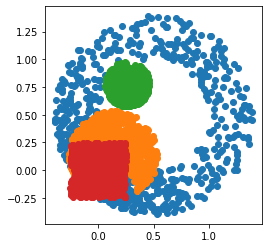

In [8]:
# cercle
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

# # plt.grid(linestyle='--')

x, y = list(zip(*M[0]))# cercle

ax.scatter(x,y)
x, y = list(zip(*M[1]))# cercle
ax.scatter(x,y)

x, y = list(zip(*M[2]))# cercle

ax.scatter(x,y)

x, y = list(zip(*M[3]))# cercle

ax.scatter(x,y)

# x, y = list(zip(*M[4]))# cercle

# ax.scatter(x,y)

ax.set_aspect(1)


**Plot 2D**

In [ ]:
import pandas as pd
# Visualisation 
from matplotlib import pyplot as plt
from matplotlib import patches as ptc
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
nb_feats= int(input('nb of features to plot '))
nb_clusters= int(input('nb of clusters to plot'))
listes=combinliste(np.arange(nb_feats),3)
Y=y ##  à commenter en cas de 2eme exécution
y=list(set(y.reshape(-1)))[:nb_clusters] ## à excuter qu'une seule fois ( pour une deuxieme exécution commenter cette ligne et la precedente)

opacity: dict = {i:1 for i in y}

    
# sc: StandardScaler = StandardScaler() # parametre à demander à l'utilisateur
# X: np.ndarray = sc.fit_transform(X)
# pca: PCA = PCA(n_components=X.shape[1]) # nombre de dimensions -- > à demander à l'utilisateur
# X: np.ndarray = pca.fit_transform(X)
j=1
data: list = []
name: dict = {i:str('%d.%d' % (j, i)) for i, val in zip(y, y)} # num des clusters


data_plot: pd.DataFrame = pd.DataFrame(X)
data_plot["prediction"] = Y
    # data_plot["prediction"] = prediction.replace([-1,1], name)
data: dict ={}
# fig = make_subplots(rows=1, cols=1)
for (i1,i2,i3) in listes:
  dataa=[]
  for i, val in zip(y, y):
    data_semi_plot: pd.DataFrame = data_plot[data_plot["prediction"] == val]
    dataa.append(go.Scatter3d(x=data_semi_plot[i1], y=data_semi_plot[i2], z=data_semi_plot[i3], name=name[val], mode='markers',marker=dict(size=6), opacity=opacity[i]))
  data[(i1,i2,i3)]=dataa

nb of features to plot 4
nb of clusters to plot4


In [ ]:

fig = make_subplots(
    rows=len(listes), 
    cols=1,
    specs=[[{"type": "scatter3d"}]]*len(listes),
    subplot_titles=[str('%d.%d.%d '% (i,j,k)) for (i,j,k )in listes])

count=0
for ((i1,i2,i3),d) in data.items():
  count+=1
  fig.add_traces(d, rows=[count]*len(d), cols=[1]*len(d))


 
fig.update_layout(width=1000,height=4000,showlegend=True)

fig.show()